In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

from sentence_transformers import SentenceTransformer
from imblearn.pipeline import Pipeline
from itertools import combinations
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

### Extraction Features

In [2]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc_lemm.csv")

In [3]:
# Conversione in un formato utile a BERT
resumes = df["Resume_str"].tolist()
    
cat = df["Category"].astype("category")
labels = cat.cat.codes
category_names = list(cat.cat.categories)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(resumes, labels, test_size=0.2, random_state=42, stratify=labels)

In [5]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
# Embedding dei testi
X_train_embed = sbert_model.encode(X_train, show_progress_bar=True)
X_test_embed = sbert_model.encode(X_test, show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

### Random Forest Classifier

In [7]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
class_counts = y_train.value_counts()
min_classes = class_counts[class_counts < class_counts.mean()].index.tolist()

print(f"Applicazione di SMOTE alle classi: {min_classes}")

target_size = int(class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applicazione di SMOTE alle classi: [4, 23, 3, 14, 2, 5, 8]


In [10]:
pipeline = Pipeline(steps=[
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [11]:
param_grid = {
    'clf__n_estimators': [400, 700],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [5, 7, 9],
    'clf__criterion' : ['gini', 'entropy'],
    'clf__min_samples_leaf': [10, 15]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(X_train_embed, y_train)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_)

GridSearchCV took 977.61 seconds for 48 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.630 (std: 0.023)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10, 'clf__n_estimators': 700}

Model with rank: 2
Mean validation score: 0.628 (std: 0.026)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 10, 'clf__n_estimators': 700}

Model with rank: 3
Mean validation score: 0.626 (std: 0.025)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10, 'clf__n_estimators': 400}

Model with rank: 4
Mean validation score: 0.624 (std: 0.025)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 10, 'clf__n_estimators': 400}

Model with rank: 5
Mean validation score: 0.621 (std: 0.022)
Parameters: {'clf__criterion': 

In [12]:
print(grid_search.best_params_)

{'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10, 'clf__n_estimators': 700}


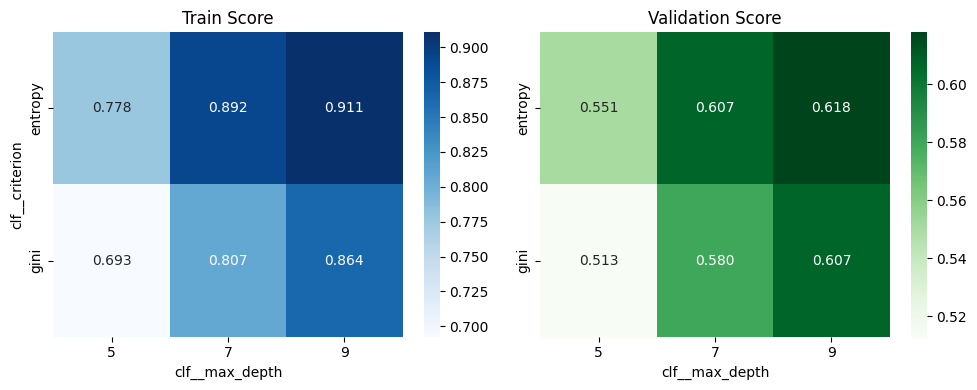

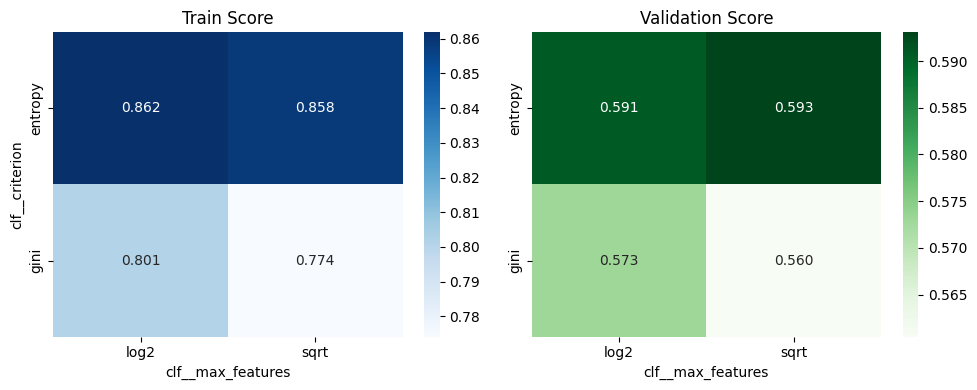

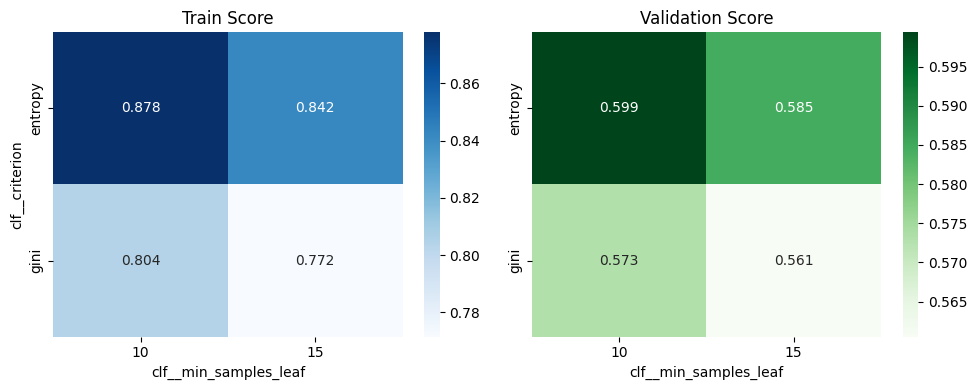

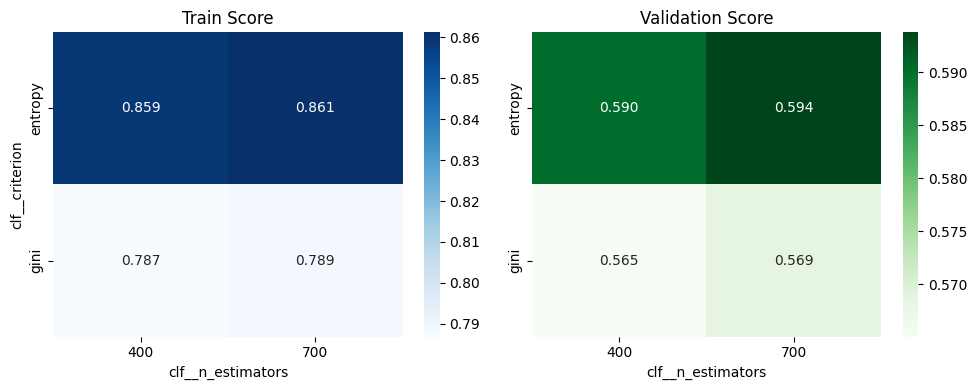

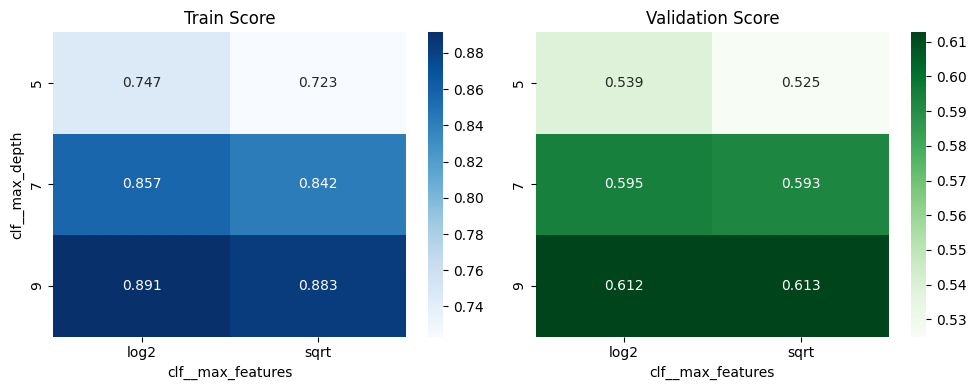

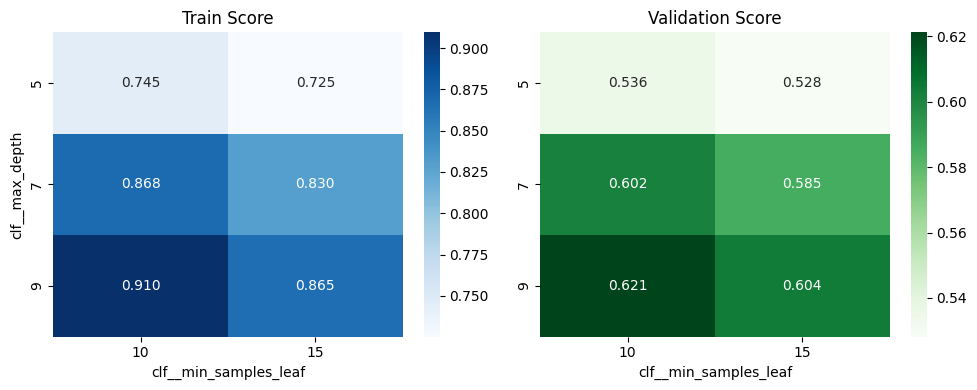

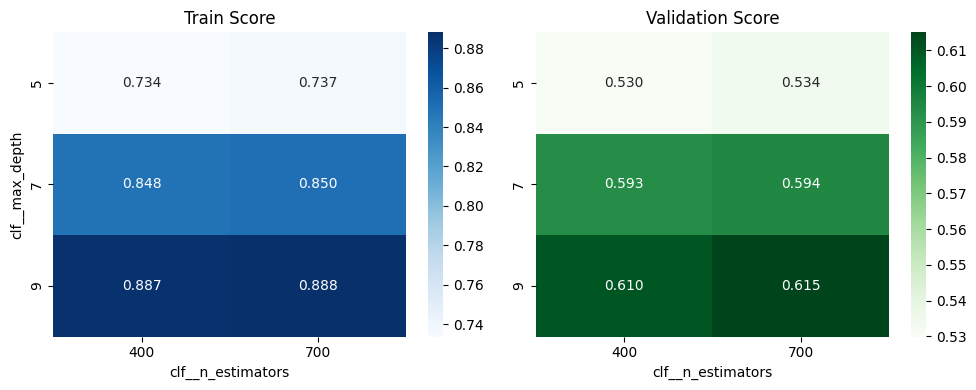

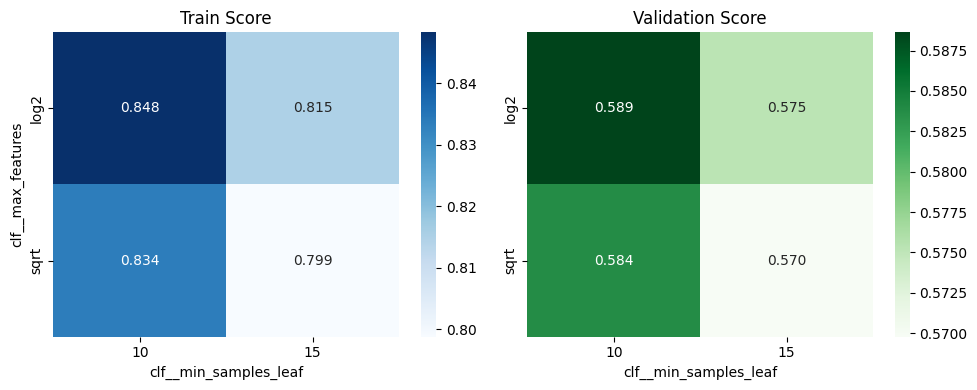

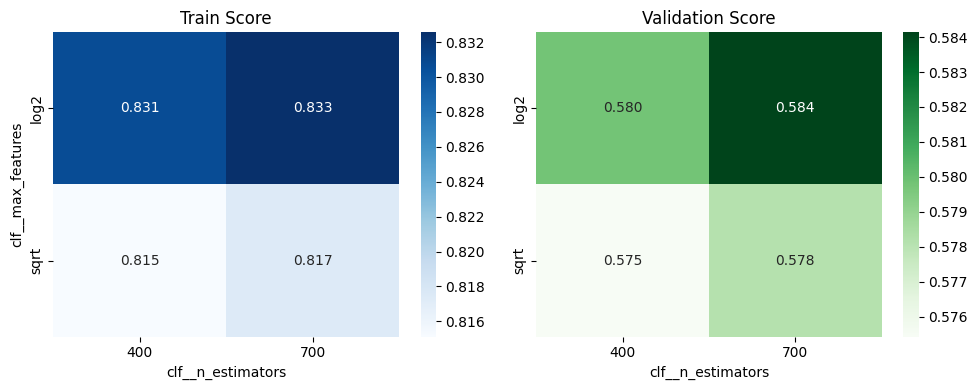

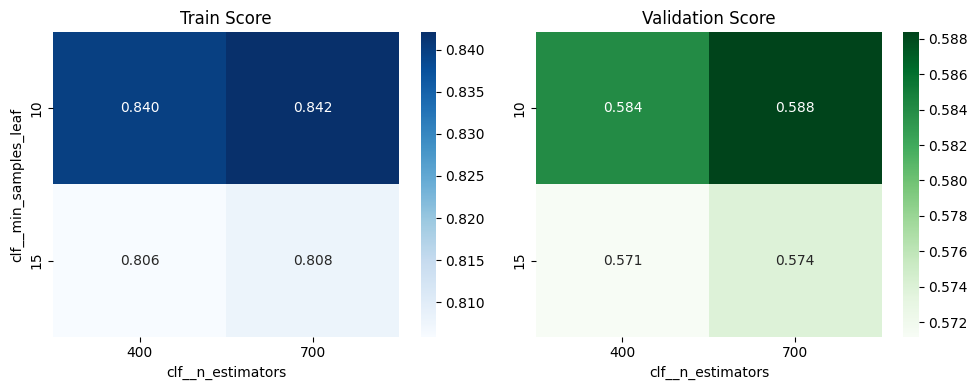

In [13]:
# DataFrame con i risultati
results = pd.DataFrame(grid_search.cv_results_)
param_cols = [col for col in results.columns if col.startswith("param_")]

# Converti tutti i parametri in stringa per la pivot table
for p in param_cols:
    results[p] = results[p].astype(str)

# Heatmap per ogni coppia di parametri
for p1, p2 in combinations(param_cols, 2):
    try:
        pivot_val = results.pivot_table(values='mean_test_score', index=p1, columns=p2)
        pivot_train = results.pivot_table(values='mean_train_score', index=p1, columns=p2)

        if pivot_val.shape[0] > 1 and pivot_val.shape[1] > 1:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            sns.heatmap(pivot_train, annot=True, fmt=".3f", cmap="Blues", ax=axes[0])
            axes[0].set_title(f"Train Score")
            axes[0].set_xlabel(p2.replace("param_", ""))
            axes[0].set_ylabel(p1.replace("param_", ""))

            sns.heatmap(pivot_val, annot=True, fmt=".3f", cmap="Greens", ax=axes[1])
            axes[1].set_title(f"Validation Score")
            axes[1].set_xlabel(p2.replace("param_", ""))
            axes[1].set_ylabel("")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Errore con {p1} e {p2}: {e}")

In [14]:
RF_Model_best = grid_search.best_estimator_
prediction = RF_Model_best.predict(X_test_embed)

In [15]:
print("Training Score: {:.2f}".format(RF_Model_best.score(X_train_embed, y_train)))
print("Test Score: {:.2f}".format(RF_Model_best.score(X_test_embed, y_test)))

Training Score: 0.93
Test Score: 0.66


In [16]:
print(classification_report(y_test, prediction, target_names=category_names))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.77      0.96      0.85        24
              ADVOCATE       0.65      0.46      0.54        24
           AGRICULTURE       0.67      0.46      0.55        13
               APPAREL       0.75      0.16      0.26        19
                  ARTS       1.00      0.05      0.09        21
            AUTOMOBILE       0.30      0.43      0.35         7
              AVIATION       0.70      0.79      0.75        24
               BANKING       0.76      0.57      0.65        23
                   BPO       0.25      0.50      0.33         4
  BUSINESS-DEVELOPMENT       0.77      0.83      0.80        24
                  CHEF       0.86      0.79      0.83        24
          CONSTRUCTION       0.75      0.68      0.71        22
            CONSULTANT       0.83      0.65      0.73        23
              DESIGNER       0.71      0.71      0.71        21
         DIGITAL-MEDIA       0.52      

<Figure size 1500x1000 with 0 Axes>

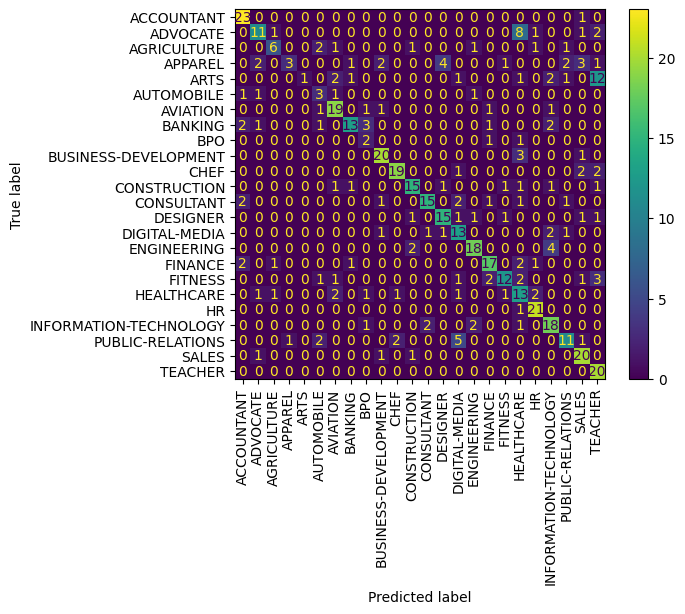

In [17]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction, display_labels=category_names)
plt.xticks(rotation=90)
plt.show()

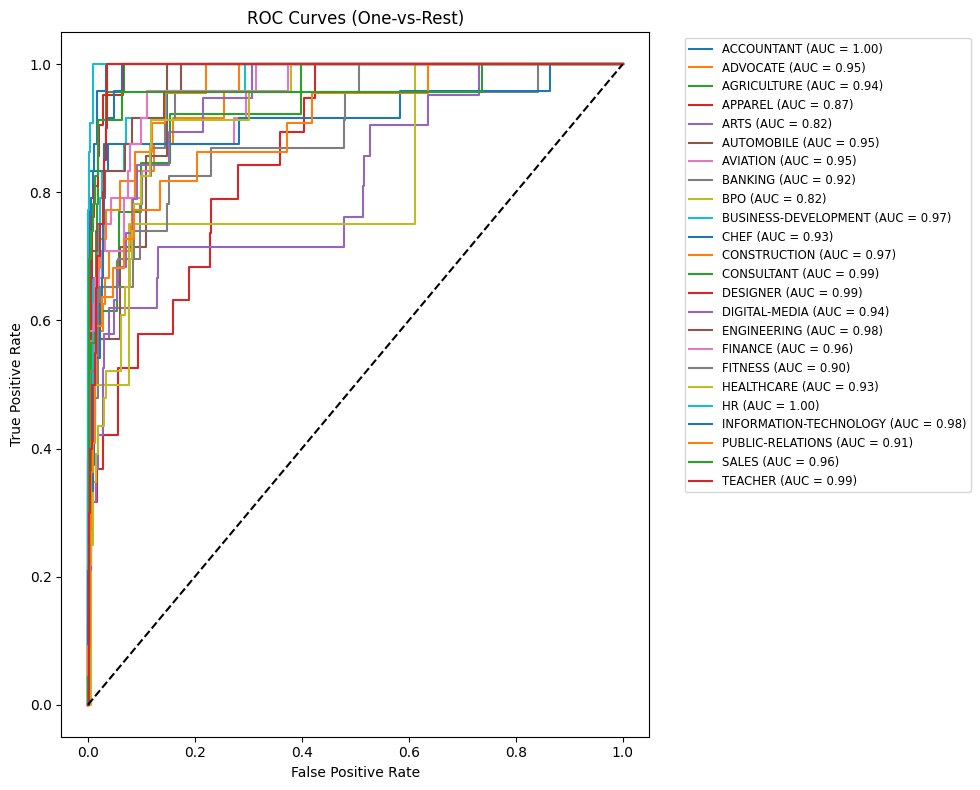

In [18]:
y_test_bin = label_binarize(y_test, classes=RF_Model_best.classes_)
y_score = RF_Model_best.predict_proba(X_test_embed)

plt.figure(figsize=(10, 8))
for i, label in enumerate(category_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

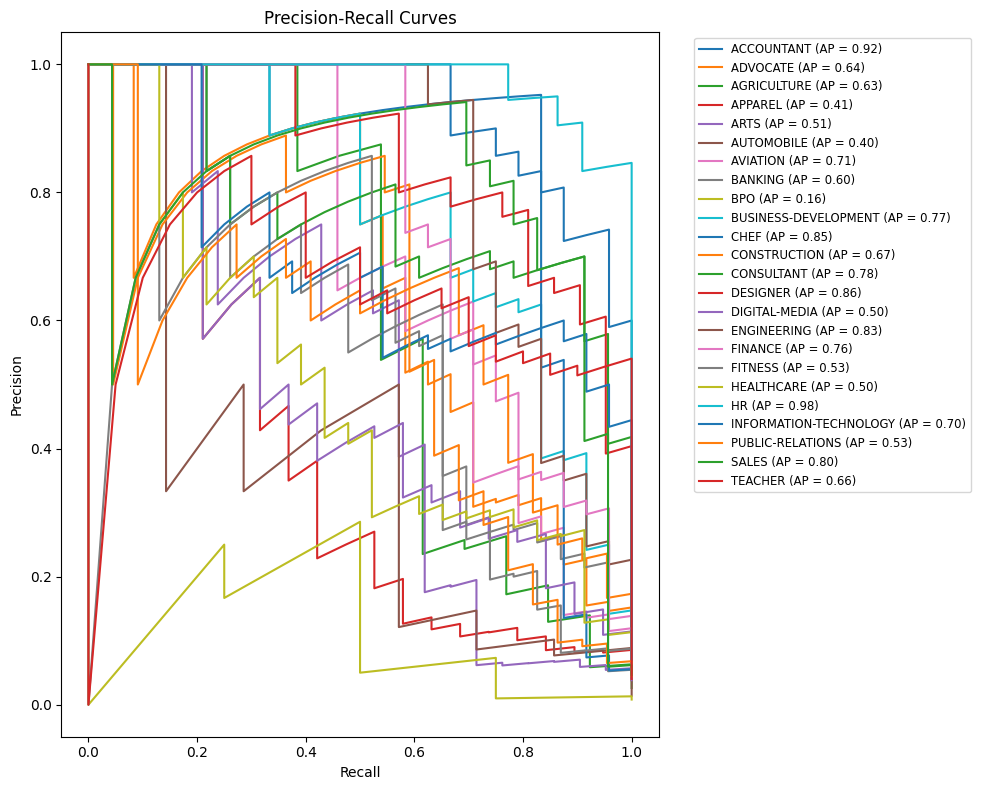

In [19]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(category_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{label} (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()